# Multiplying 2 numbers with a Deep Network

One of the great powers of deep nueral networks is their ability to model very complex functions without requiring much knowledge from the person building the model. This means you only need a relatively small number of building blocks to estimate any function, provided you add enough nodes.

In this example I want to build a model that multiplies 2 numbers whose values range from -10 to +10 using a deep network. There are a couple ways to get a mathematical multiply operation in Keras layers, but here I'm going to do it with an MLP using Keras Dense layers.

In this first cell, I define the model. It is a little more complicated than it probably needs to be since I copied it from another project that could use multiple GPUs for the training. It also builds the model from 2 parts: *DefineCommonModel* and *DefineCommonOutput* (also a left over). I stick with linear and tanh activation functions since they can both easily deal with negative numbers.

The model itself has over 6M trainable parameters.

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf

GPUS    = 0
NINPUTS = 2
Nouts   = 200

#-----------------------------------------------------
# DefineModel
#-----------------------------------------------------
# This is used to define the model. It is only called if no model
# file is found in the model_checkpoints directory.
def DefineModel():

    # If GPUS==0 this will force use of CPU, even if GPUs are present
    # If GPUS>1 this will force the CPU to serve as orchestrator
    # If GPUS==1 this will do nothing, allowing GPU to act as its own orchestrator
    if GPUS!=1: tf.device('/cpu:0')

    # Here we build the network model.
    # This model is made of multiple parts. The first handles the
    # inputs and identifies common features. The rest are branches with
    # each determining an output parameter from those features.
    inputs         = Input(shape=(NINPUTS,), name='waveform')
    commonmodel    = DefineCommonModel(inputs)
    commonoutput   = DefineCommonOutput(commonmodel)

    model          = Model(inputs=inputs, outputs=commonoutput)

    # Compile the model, possibly using multiple GPUs
    opt = Adadelta(clipnorm=1.0)
    if GPUS<=1 :
        final_model = model
    else:
        final_model = multi_gpu_model( model, gpus=GPUS )

    #final_model.add_loss(customLoss( input_true, commonoutput, input_incov ) )
    final_model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse', 'accuracy'])
    
    return final_model

#-----------------------------------------------------
# DefineCommonModel
#-----------------------------------------------------
def DefineCommonModel(inputs):
    x = Flatten(name='top_layer1')(inputs)
    x = Dense(int(Nouts*5), name='common_layer1', activation='linear', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts*5), name='common_layer2', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts*5), name='common_layer3', activation='linear', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts*5), name='common_layer4', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(int(Nouts*5), name='common_layer5', activation='linear', kernel_initializer="glorot_uniform")(x)
    return x

#-----------------------------------------------------
# DefineCommonOutput
#-----------------------------------------------------
def DefineCommonOutput(inputs):
    #x = tf.keras.layers.concatenate( inputs )
    x = Dense(Nouts*5, name='common_out1', activation='linear', kernel_initializer="glorot_uniform")(inputs)
    x = Dense(Nouts*5, name='common_out2', activation='tanh', kernel_initializer="glorot_uniform")(x)
    x = Dense(Nouts, name='common_out3', activation='linear', kernel_initializer="glorot_uniform")(x)
    x = Dense(1, name='outputs', activation='linear', kernel_initializer="glorot_uniform")(x)
    return x

model = DefineModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
waveform (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
top_layer1 (Flatten)         (None, 2)                 0         
_________________________________________________________________
common_layer1 (Dense)        (None, 1000)              3000      
_________________________________________________________________
common_layer2 (Dense)        (None, 1000)              1001000   
_________________________________________________________________
common_layer3 (Dense)        (None, 1000)              1001000   
_________________________________________________________________
common_layer4 (Dense)        (None, 1000)              1001000   
_________________________________________________________________
common_layer5 (Dense)        (None, 1000)              100100

## Generate training set and fit

In these next two cells I generate a training set and fit the model, but only for a few epochs with a large batch size.

In [2]:
# 
# Generate dataframes for features and labels
#
import pandas as pd
import numpy as np

X = []
Z = []
for x in np.arange(-10.0, 10.1, 0.1):
    for y in np.arange(-10.0, 10.1, 0.1):
        z = x*y
        X.append([x,y])  # features
        Z.append([z])    # labels

df = pd.DataFrame(X, columns=['x', 'y'])
labelsdf = pd.DataFrame(Z, columns=['z'])

In [4]:
EPOCHS = 10  # (in addition to anything already done)
BS     = 1000

# Fit the model
history = model.fit(
    x = df,
    y = labelsdf,
    batch_size = BS,
    epochs=EPOCHS,
    #validation_split=0.2,
    shuffle=True,
    verbose=0,
    use_multiprocessing=False
)

model.save('multiply_model01.h5')

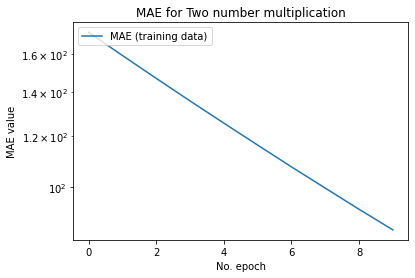

In [5]:
import matplotlib.pyplot as plt

# Plot history: MAE
plt.yscale('log')
plt.plot(history.history['loss'], label='MAE (training data)')
#plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Two number multiplication')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [6]:
Xtest = []
Ztest = []
for x in np.arange(-9.95, 10.05, 0.1):
    for y in np.arange(-9.95, 10.05, 0.1):
#for x in np.arange(-10.0, 10.1, 0.1):
#    for y in np.arange(-10.0, 10.1, 0.1):
        z = x*y
        Xtest.append([x,y])  # features
        Ztest.append([z])    # labels

df_test = pd.DataFrame(Xtest, columns=['x', 'y'])

y_pred = model(df_test).numpy()
diff = (Ztest - y_pred)/Ztest
print(diff[:10])


[[0.5176523 ]
 [0.51282898]
 [0.50792043]
 [0.5029245 ]
 [0.49783895]
 [0.49266139]
 [0.48738957]
 [0.482021  ]
 [0.47655314]
 [0.47098343]]


In [ ]:
9.95*9.95